In [1]:
import os 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import sklearn

from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from rgf.sklearn import RGFClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

In [2]:
# Loading the train dataset
path="../Data/"
train = pd.read_csv(path+'Train.csv')
test = pd.read_csv(path+'Test.csv')
# Display the first few rows of the datasets and their shape
display("Train", train.head(), train.shape, "Test", test.head(), test.shape)

'Train'

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid,target
0,ID_266671248032267278,266671,Kenya,248032,267278,Type_1,8448.0,8448.0,2022-08-30,2022-09-06,7,Repeat Loan,120.85,0.014305,121.0,0
1,ID_248919228515267278,248919,Kenya,228515,267278,Type_1,25895.0,25979.0,2022-07-30,2022-08-06,7,Repeat Loan,7768.50,0.300000,7794.0,0
2,ID_308486370501251804,308486,Kenya,370501,251804,Type_7,6900.0,7142.0,2024-09-06,2024-09-13,7,Repeat Loan,1380.00,0.200000,1428.0,0
3,ID_266004285009267278,266004,Kenya,285009,267278,Type_1,8958.0,9233.0,2022-10-20,2022-10-27,7,Repeat Loan,2687.40,0.300000,2770.0,0
4,ID_253803305312267278,253803,Kenya,305312,267278,Type_1,4564.0,4728.0,2022-11-28,2022-12-05,7,Repeat Loan,1369.20,0.300000,1418.0,0


(68654, 16)

'Test'

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid
0,ID_269404226088267278,269404,Kenya,226088,267278,Type_1,1919.0,1989.0,2022-07-27,2022-08-03,7,Repeat Loan,575.7,0.300000,597.0
1,ID_255356300042267278,255356,Kenya,300042,267278,Type_1,2138.0,2153.0,2022-11-16,2022-11-23,7,Repeat Loan,0.0,0.000000,0.0
2,ID_257026243764267278,257026,Kenya,243764,267278,Type_1,8254.0,8304.0,2022-08-24,2022-08-31,7,Repeat Loan,207.0,0.025079,208.0
3,ID_264617299409267278,264617,Kenya,299409,267278,Type_1,3379.0,3379.0,2022-11-15,2022-11-22,7,Repeat Loan,1013.7,0.300000,1014.0
4,ID_247613296713267278,247613,Kenya,296713,267278,Type_1,120.0,120.0,2022-11-10,2022-11-17,7,Repeat Loan,36.0,0.300000,36.0


(18594, 15)

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68654 entries, 0 to 68653
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           68654 non-null  object 
 1   customer_id                  68654 non-null  int64  
 2   country_id                   68654 non-null  object 
 3   tbl_loan_id                  68654 non-null  int64  
 4   lender_id                    68654 non-null  int64  
 5   loan_type                    68654 non-null  object 
 6   Total_Amount                 68654 non-null  float64
 7   Total_Amount_to_Repay        68654 non-null  float64
 8   disbursement_date            68654 non-null  object 
 9   due_date                     68654 non-null  object 
 10  duration                     68654 non-null  int64  
 11  New_versus_Repeat            68654 non-null  object 
 12  Amount_Funded_By_Lender      68654 non-null  float64
 13  Lender_portion_F

In [4]:
[x for x in train.columns if "_id" in x.lower() or x.lower()=="id"]

['ID', 'customer_id', 'country_id', 'tbl_loan_id', 'lender_id']

In [5]:
class Preprocessing :
    def __init__(self, train, test) :
        self.train = train 
        self.test = test
        self.train_shape = train.shape
        self.test_shape = test.shape
        self.train_columns = train.columns
        self.test_columns = test.columns
        self.id_cols = [x for x in train.columns if "_id" in x.lower() or x.lower()=="id"]
        self.target_col = self.train.columns.difference(self.test.columns)
        self.cat_cols = [x for x in train.columns if train[x].dtype=="O" and x not in self.id_cols]
        self.num_cols = [x for x in train.columns if x not in self.cat_cols and x not in self.id_cols and x not in self.target_col]
        self.test_ids = self.test[self.id_cols]
        
    
    def all_data(self) :
        return pd.concat([self.train, self.test], axis=0)   
    
    def drop_id_cols(self) :
        self.train.drop(columns=self.id_cols, inplace=True)
        self.test.drop(columns=self.id_cols, inplace=True)
        return self.train, self.test
    
    def standardize(self) :
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        self.train[self.num_cols] = scaler.fit_transform(self.train[self.num_cols])
        self.test[self.num_cols] = scaler.transform(self.test[self.num_cols])
        return self.train, self.test
    
    def frequency_encoding_cat_cols(self) :
        for col in self.cat_cols :
            encoding = self.all_data()[col].value_counts()
            self.train[col] = self.train[col].map(encoding)
            self.test[col] = self.test[col].map(encoding)
        return self.train, self.test
    
    def fillna(self) :
        self.train.fillna(0, inplace=True)
        self.test.fillna(0, inplace=True)
        return self.train, self.test
    
    def preprocess(self) :
        self.drop_id_cols()
        self.standardize()
        self.frequency_encoding_cat_cols()
        self.fillna()
        return self.train, self.test
    
preprocessor = Preprocessing(train, test)
train, test = preprocessor.preprocess()
    

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68654 entries, 0 to 68653
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   loan_type                    68654 non-null  int64  
 1   Total_Amount                 68654 non-null  float64
 2   Total_Amount_to_Repay        68654 non-null  float64
 3   disbursement_date            68654 non-null  int64  
 4   due_date                     68654 non-null  int64  
 5   duration                     68654 non-null  float64
 6   New_versus_Repeat            68654 non-null  int64  
 7   Amount_Funded_By_Lender      68654 non-null  float64
 8   Lender_portion_Funded        68654 non-null  float64
 9   Lender_portion_to_be_repaid  68654 non-null  float64
 10  target                       68654 non-null  int64  
dtypes: float64(6), int64(5)
memory usage: 5.8 MB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18594 entries, 0 to 18593
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   loan_type                    18594 non-null  int64  
 1   Total_Amount                 18594 non-null  float64
 2   Total_Amount_to_Repay        18594 non-null  float64
 3   disbursement_date            18594 non-null  int64  
 4   due_date                     18594 non-null  int64  
 5   duration                     18594 non-null  float64
 6   New_versus_Repeat            18594 non-null  int64  
 7   Amount_Funded_By_Lender      18594 non-null  float64
 8   Lender_portion_Funded        18594 non-null  float64
 9   Lender_portion_to_be_repaid  18594 non-null  float64
dtypes: float64(6), int64(4)
memory usage: 1.4 MB


In [8]:
train.target.value_counts()

target
0    67396
1     1258
Name: count, dtype: int64

In [9]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=98)
models = {
    "LogisticRegression" : LogisticRegression(),
    "RandomForest" : RandomForestClassifier(),
    "SVC" : SVC(),
    "KNeighbors" : KNeighborsClassifier(),
    "DecisionTree" : DecisionTreeClassifier(),
    "LGBM" : LGBMClassifier(),
    "XGB" : XGBClassifier(),
    "CatBoost" : CatBoostClassifier(),
    "RGF" : RGFClassifier()
}

c:\Users\origin\anaconda3\Lib\site-packages\rgf\utils.py:224: UserWarning: Cannot find FastRGF executable files. FastRGF estimators will be unavailable for usage.
  warnings.warn("Cannot find FastRGF executable files. "


In [23]:
class ModelBenchmarching:
    def __init__(self, models, cv, train, test):
        self.models = models
        self.cv = cv
        self.results = {}
        self.train = train
        self.X = self.train.drop(columns="target")
        self.y = self.train.target
        self.X_test = test[self.X.columns]
        self.skf = StratifiedKFold(n_splits=self.cv, shuffle=True, random_state=98)
        
    def fit(self):
        for name, model in self.models.items():
            accuracy = []
            f1 = []
            precision = []
            recall = []
            roc = []
            for train_idx, test_idx in self.skf.split(self.X, self.y):
                X_train, X_test = self.X.iloc[train_idx], self.X.iloc[test_idx]
                y_train, y_test = self.y.iloc[train_idx], self.y.iloc[test_idx]
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                accuracy.append(accuracy_score(y_test, y_pred))
                f1.append(f1_score(y_test, y_pred))
                precision.append(precision_score(y_test, y_pred))
                recall.append(recall_score(y_test, y_pred))
                roc.append(roc_auc_score(y_test, y_pred))
            self.results[name] = {
                "accuracy" : np.mean(accuracy),
                "f1" : np.mean(f1),
                "precision" : np.mean(precision),
                "recall" : np.mean(recall),
                "roc" : np.mean(roc)
            }
        return self.results
    
    def plot_results(self):
        results = pd.DataFrame(self.results)
        results.plot(kind="bar", figsize=(15, 6))
        plt.xticks(rotation=0)
        plt.show()
        
    def predict(self):
        for name, model in self.models.items():
            model.fit(self.X, self.y)
            self.X_test["target"] = model.predict(self.X_test)
            self.X_test[["ID", "target"]].to_csv(f"../Submissions/{name}.csv", index=False)
    
    def ensembling_top_3_f1(self):
        models = list(self.results.keys())
        models = sorted(models, key=lambda x: self.results[x]["f1"], reverse=True)[:3]
        for name in models:
            model = self.models[name]
            model.fit(self.X, self.y)
            self.X_test["target"] = model.predict(self.X_test)
            self.X_test["ID"] = preprocessor.test_ids["ID"]
            self.X_test[["ID", "target"]].to_csv(f"../Submissions/{name}.csv", index=False)
            self.X_test.drop(columns=["ID", "target"], inplace=True)
            
            
    
model_benchmarching = ModelBenchmarching(models, 5, train, test)
        
        

In [24]:
model_benchmarching.fit()

c:\Users\origin\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\origin\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

[LightGBM] [Info] Number of positive: 1007, number of negative: 53916
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1629
[LightGBM] [Info] Number of data points in the train set: 54923, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018335 -> initscore=-3.980452
[LightGBM] [Info] Start training from score -3.980452
[LightGBM] [Info] Number of positive: 1006, number of negative: 53917
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1629
[LightGBM] [Info] Number of data points in the train set: 54923, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018317 -> initscore=-3.981464
[Lig

{'LogisticRegression': {'accuracy': 0.9818655815361469,
  'f1': 0.12128100273428992,
  'precision': 0.5563636363636364,
  'recall': 0.06835198886991714,
  'roc': 0.5336344150840262},
 'RandomForest': {'accuracy': 0.9904302633532461,
  'f1': 0.6655526428124402,
  'precision': 0.9227481995971247,
  'recall': 0.5214475431606906,
  'roc': 0.7603157360451254},
 'SVC': {'accuracy': 0.9816762321588204,
  'f1': 0.0,
  'precision': 0.0,
  'recall': 0.0,
  'roc': 0.5},
 'KNeighbors': {'accuracy': 0.9817053654435981,
  'f1': 0.17676414019116288,
  'precision': 0.503794376401587,
  'recall': 0.10731044077657623,
  'roc': 0.5526685135140053},
 'DecisionTree': {'accuracy': 0.9893669769623527,
  'f1': 0.7052888902756578,
  'precision': 0.7185426489941439,
  'recall': 0.6939796370075255,
  'roc': 0.8444303221732798},
 'LGBM': {'accuracy': 0.9902263430900982,
  'f1': 0.6743212830707241,
  'precision': 0.86289498305433,
  'recall': 0.5548536014671472,
  'roc': 0.7766033112655077},
 'XGB': {'accuracy': 0

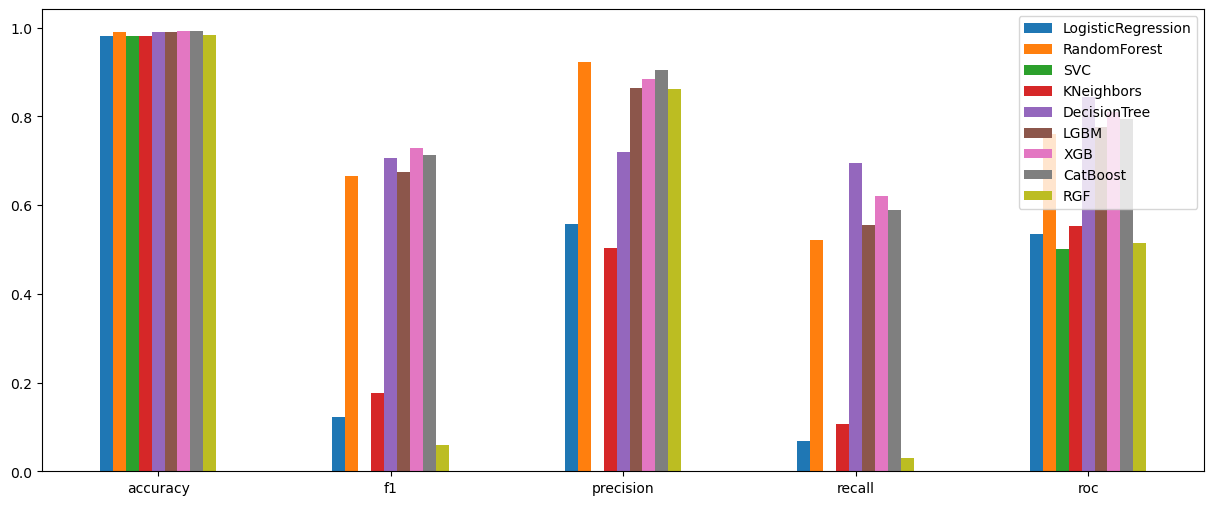

In [25]:
model_benchmarching.plot_results()

In [ ]:
model_benchmarching.ensembling_top_3_f1()

C:\Users\origin\AppData\Local\Temp\ipykernel_25736\2505313486.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.X_test["target"] = model.predict(self.X_test)


Learning rate set to 0.062689
0:	learn: 0.5657048	total: 27.8ms	remaining: 27.7s
1:	learn: 0.4665292	total: 64.5ms	remaining: 32.2s
2:	learn: 0.3884246	total: 112ms	remaining: 37.1s
3:	learn: 0.3239307	total: 155ms	remaining: 38.6s
4:	learn: 0.2749525	total: 193ms	remaining: 38.4s
5:	learn: 0.2372418	total: 232ms	remaining: 38.4s
6:	learn: 0.2065144	total: 273ms	remaining: 38.7s
7:	learn: 0.1805852	total: 307ms	remaining: 38.1s
8:	learn: 0.1611933	total: 355ms	remaining: 39.1s
9:	learn: 0.1464521	total: 393ms	remaining: 38.9s
10:	learn: 0.1340139	total: 431ms	remaining: 38.7s
11:	learn: 0.1239730	total: 475ms	remaining: 39.1s
12:	learn: 0.1151517	total: 514ms	remaining: 39s
13:	learn: 0.1074575	total: 549ms	remaining: 38.7s
14:	learn: 0.1012941	total: 588ms	remaining: 38.6s
15:	learn: 0.0964091	total: 621ms	remaining: 38.2s
16:	learn: 0.0925159	total: 659ms	remaining: 38.1s
17:	learn: 0.0891120	total: 694ms	remaining: 37.9s
18:	learn: 0.0859905	total: 732ms	remaining: 37.8s
19:	learn: 

: 